# Laboratory 2

### Part 0

In [1]:
import pandas as pd
from easymoney.money import EasyPeasy
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from math import sqrt

from numpy import mean
from numpy import std

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

import sklearn as sk
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

### Part 1.

In [3]:
feature_matrix = pd.read_csv("C:\\Users\\stan_\\Downloads\\Telegram Desktop\\IMDb movies.csv")
feature_matrix.head(2)

imdb_title_id                        title               original_title  \
0     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
1     tt0001892               Den sorte drøm               Den sorte drøm   

   year date_published                    genre  duration           country  \
0  1906     1906-12-26  Biography, Crime, Drama        70         Australia   
1  1911     1911-08-19                    Drama        53  Germany, Denmark   

  language      director  ...  \
0      NaN  Charles Tait  ...   
1      NaN     Urban Gad  ...   

                                              actors  \
0  Elizabeth Tait, John Tait, Norman Campbell, Be...   
1  Asta Nielsen, Valdemar Psilander, Gunnar Helse...   

                                         description avg_vote votes  budget  \
0  True story of notorious Australian outlaw Ned ...      6.1   537  $ 2250   
1  Two men of high rank are both wooing the beaut...      5.9   171     NaN   

   usa_gross_income worlwide_gross_income metascore reviews_from_users  \
0               NaN                   NaN       NaN                7.0   
1               NaN                   NaN       NaN                4.0   

   reviews_from_critics  
0                   7.0  
1                   2.0  

[2 rows x 22 columns]

In [4]:
budget_f = feature_matrix[['year', 'budget']]
budget = budget_f.to_numpy()
budget = [list(arr) for arr in budget]

for i in range(len(budget)):
    if isinstance(budget[i][1], str):
        budget[i][1] = budget[i][1].split(' ')
        if budget[i][1][0] == '$':
            budget[i][1][0] = 'USD'

In [5]:
def dollar_to_usd(budget: list):
    for i in range(len(budget)):
        if isinstance(budget[i], str):
            budget[i] = budget[i].split(' ')
            if budget[i][0] == '$':
                budget[i][0] = 'USD'
    
    return budget

Убираю строки с ценниками в XAU. Это не валюта отдельного государства, а золото. Конвертация в него не выходит средствами `easymoney`. Подробности ниже после составления отображения из валюты в регион.

In [6]:
xau_indexes = []
for i in range(len(budget)):
    if isinstance(budget[i][1], list):
        if budget[i][1][0] == 'XAU':
            xau_indexes.append(i)

xau_indexes

[16897]

In [7]:
budget[xau_indexes[0]]

[1976, ['XAU', '4300000']]

In [8]:
spotted_f = feature_matrix[(feature_matrix['year'] == 1976) & (feature_matrix['budget'] == 'XAU 4300000')]
spotted_f.index.values

array([16897], dtype=int64)

In [9]:
feature_matrix = feature_matrix.drop(axis=0, index=[16897])

In [10]:
def exclude_rows_by_condition(df: pd.DataFrame, indexes: list) -> pd.DataFrame:
    for i in indexes:
        df.drop(axis=0, index=[i], inplace=True)

    return df

Успешно исключили запись с золотом и без данных о доходах, которые мы пытаемся прогнозировать.

In [11]:
budget_f = feature_matrix[['year', 'budget']]
budget = budget_f.to_numpy()
budget = [list(arr) for arr in budget]

for i in range(len(budget)):
    if isinstance(budget[i][1], str):
        budget[i][1] = budget[i][1].split(' ')
        if budget[i][1][0] == '$':
            budget[i][1][0] = 'USD'

len(budget)

60197

In [12]:
curr_list = set()

for b in budget:
    if isinstance(b[1], list):
        curr_list.add(b[1][0])

print(curr_list)
print(len(curr_list))

{'PTE', 'PHP', 'DKK', 'GRD', 'SIT', 'MXN', 'SKK', 'JPY', 'CZK', 'EUR', 'CAD', 'HKD', 'ARS', 'UAH', 'MYR', 'NLG', 'IDR', 'ROL', 'YUM', 'PLN', 'LTL', 'JMD', 'PKR', 'BGL', 'RUR', 'HRK', 'EGP', 'BND', 'MTL', 'IEP', 'INR', 'DOP', 'LVL', 'ITL', 'CHF', 'ESP', 'BDT', 'ZAR', 'NZD', 'TWD', 'TRL', 'VEB', 'ATS', 'FIM', 'KRW', 'FRF', 'ILS', 'PYG', 'DEM', 'CLP', 'SEK', 'SGD', 'AUD', 'IRR', 'COP', 'NOK', 'BRL', 'GBP', 'ISK', 'NGN', 'HUF', 'NPR', 'USD', 'THB', 'CNY', 'EEK', 'BEF'}
67


In [13]:
curr_to_region = {
    'BND' : 'Brunei Darussalam',
    'RUR' : 'Russian Federation',
    'JMD' : 'Jamaica',
    'IDR' : 'Republic of Indonesia',
    'NZD' : 'New Zealand',
    'ISK' : 'Iceland',
    'SKK' : 'Republic of Slovenia',
    'BGL' : 'Republic of Bulgaria',
    'NPR' : 'Federal Democratic Republic of Nepal',
    'YUM' : 'Yugoslavia',
    'DOP' : 'Dominican Republic',
    'TRL' : 'Turkey',
    'PYG' : 'Republic of Paraguay',
    'EEK' : 'Republic of Estonia',
    'PTE' : 'Portuguese Republic',
    'IRR' : 'Islamic Republic of Iran',
    'MTL' : 'Republic of Malta',
    'ZAR' : 'Republic of South Africa',
    'COP' : 'Republic of Colombia',
    'SIT' : 'Republic of Slovenia',
    'BEF' : 'Kingdom of Belgium',
    'ROL' : 'Romania',
    'BDT' : 'People\'s Republic of Bangladesh',
    'EGP' : 'Arab Republic of Egypt',
    'GRD' : 'Hellenic Republic',
    'MYR' : 'Malaysia',
    'LTL' : 'Republic of Lithuania',
    'ARS' : 'Argentine Republic',
    'CLP' : 'Republic of Chile',
    'HRK' : 'Republic of Croatia',
    'IEP' : 'Ireland',
    'ILS' : 'State of Israel',
    'ITL' : 'Italian Republic',
    'LVL' : 'Republic of Latvia',
    'NGN' : 'Federal Republic of Nigeria',
    'NLG' : 'Netherlands',
    'PHP' : 'Republic of the Philippines',
    'PKR' : 'Islamic Republic of Pakistan',
    'TWD' : 'Taiwan',
    'UAH' : 'Ukraine',
    'VEB' : 'Venezuela',
    'XAU' : '',
    'MXN' : 'Mexico',
    'GBP' : 'United Kingdom',
    'HUF' : 'Hungary',
    'DKK' : 'Denmark',
    'CHF' : 'Switzerland',
    'KRW' : 'South Korea',
    'SEK' : 'Sweden',
    'CAD' : 'Canada',
    'NOK' : 'Norway',
    'INR' : 'India',
    'USD' : 'USA',
    'PLN' : 'Poland',
    'SGD' : 'Singapore',
    'DEM' : 'Germany',
    'AUD' : 'Australia',
    'HKD' : 'Hong Kong',
    'ATS' : 'Austria',
    'ESP' : 'Spain',
    'JPY' : 'Japan',
    'CZK' : 'Czech Republic',
    'FRF' : 'French republic',
    'BRL' : 'Brazil',
    'EUR' : 'Germany',
    'THB' : 'Thailand',
    'CNY' : 'China',
    'FIM' : 'Finland'
}

len(curr_to_region)

68

In [14]:
curr_to_region_set = set(curr_to_region)
curr_list.difference(curr_to_region_set)

set()

В данных обнаружились ценники за фильм в золоте - XAU. Убираю, так как их не ясно, как нормализовывать через `easymoney`. Также `ep.currency_converter()` выдает ошибку:

> Data could not obtained for 'XAU' from the European Central Bank database currently cached.

In [15]:
### Код для презентации ошибки
# ep = EasyPeasy()
# 
# ep.currency_converter(100, 'XAU', 'USD', 2000)
###

Тестирование нормализации

In [16]:
# ep = EasyPeasy()

# # date_t = date(1927, 2, 6)
# time_format = "%d/%m/%Y"
# # print(date_t.strftime(time_format))

# # ep.currency_converter(amount=1236166, from_currency='USD', to_currency='USD', date=date(1927,2,6).strftime(time_format))
# ep.normalize(amount=100, region="Denmark", from_year=1980, to_year="latest", base_currency="USD", pretty_print=True)

Рассчитываем ценники на момент выхода картины. Убираем записи, которые нельзя нормализовать.

In [17]:
c = EasyPeasy()

not_notmalized = []
for i in range(len(budget)):
    if isinstance(budget[i][1], list):
        region = curr_to_region.get(budget[i][1][0])
        amount = int(budget[i][1][1])
        from_year = budget[i][0]

        exclude_l = ['PYG', 'DOP', 'JMD', 'BDT', 'BND', 'EGP', 
                     'NPR', 'PKR', 'YUM', 'IRR', 'CLP', 'TWD', 
                     'COP', 'ARS', 'UAH', 'NGN', 'VEB']
        
        # YUM, TWD, VEB(VEF) - special regional or cache errors

        if budget[i][1][0] in exclude_l:
            not_notmalized.append(budget[i])
            continue

        budget[i][1] = c.normalize(amount=amount, 
                                    region=region, 
                                    base_currency='USD',
                                    from_year=from_year,
                                    to_year=from_year)

In [18]:
len(not_notmalized)

96

In [19]:
not_notmalized_years = [x[0] for x in not_notmalized]
not_notmalized_budget = [x[1][0] + ' ' + x[1][1] for x in not_notmalized]

In [20]:
spotted_f = feature_matrix[(feature_matrix['year'].isin(not_notmalized_years)) & (feature_matrix['budget'].isin(not_notmalized_budget))]
print(len(spotted_f))
print(spotted_f.index.values)

96
[21096 30690 31062 34779 38442 39254 40043 40823 40976 41016 41181 42529
 43134 44096 44486 44526 44795 44882 44936 45127 45172 45288 45766 46731
 46836 47172 47604 47670 48045 48178 48391 48633 49107 49272 49366 49718
 49795 49994 50008 50883 51011 51231 51366 51421 51473 51487 51599 52242
 53803 54064 54292 54646 54907 55409 55613 55762 55832 55833 55834 55835
 55836 55837 55838 55839 55840 55842 55843 55844 55936 56092 56137 57029
 57266 57446 57452 57500 57511 57512 57514 57592 57916 58047 58082 58128
 58411 58484 58603 58631 58632 58703 59061 59606 59924 59946 60033 60065]


In [21]:
feature_matrix.drop(axis=0, index=spotted_f.index.values, inplace=True)

In [22]:
len(feature_matrix)

60101

In [23]:
for entry in not_notmalized:
    budget.remove(entry)
len(budget)

60101

In [24]:
budget = [x[1] for x in budget]

feature_matrix['budget'] = budget
# feature_matrix

Year Month Day influence

In [25]:
date_published = feature_matrix['date_published']

yearMonthDay_l = []
for date in date_published.to_list():
    entries = date.split('-')
    yearMonthDay_l.append([])
    for entry in entries:
        yearMonthDay_l[-1].append(str(int(entry)))

years = []
months = []
days = []
all_l = [years, months, days]

from math import nan

for i in range(len(yearMonthDay_l)):
    if len(yearMonthDay_l[i]) == 1:
        all_l[0].append(yearMonthDay_l[i][0])
        all_l[1].append(nan)
        all_l[2].append(nan)
    elif len(yearMonthDay_l[i]) == 2:
        all_l[0].append(yearMonthDay_l[i][0])
        all_l[1].append(yearMonthDay_l[i][1])
        all_l[2].append(nan)
    elif len(yearMonthDay_l[i]) == 3:
        all_l[0].append(yearMonthDay_l[i][0])
        all_l[1].append(yearMonthDay_l[i][1])
        all_l[2].append(yearMonthDay_l[i][2])

f_m = feature_matrix.copy(deep=True)
f_m['month'] = months
f_m['day'] = days
f_m['year'] = years

df_months = f_m.pop('month')
df_days = f_m.pop('day')
df_year = f_m.pop('year')
f_m.insert(4, df_months.name, df_months)
f_m.insert(5, df_days.name, df_days)
f_m.insert(3, df_year.name, df_year)
f_m = f_m.drop(index=[19889], axis=0)
f_m.dropna(subset=['worlwide_gross_income', 'budget'], inplace=True)

In [26]:
ymd = f_m[['year', 'month', 'day', 'date_published']]
ymd

year month day date_published
155    1920     2  27     1920-02-27
198    1921    12   2     1921-12-02
232    1923     1   8     1923-01-08
238    1921     2   6     1921-02-06
334    1923    11   4     1923-11-04
...     ...   ...  ..            ...
60171  2012     9  10     2012-09-10
60179  2010     4  28     2010-04-28
60180  2012     7  28     2012-07-28
60185  2013     4  11     2013-04-11
60197  2013     6  15     2013-06-15

[9132 rows x 4 columns]

In [27]:
ymd_29 = ymd[ymd['day'] == '29']
ymd_29[ymd_29['year'] == 2007]
len(f_m)

9132

In [28]:
f_na = f_m.dropna()
f_mv = f_na[['month', 'avg_vote']]

month_str = [str(x) for x in range(1, 13)]
month_mean = np.zeros(12)

for i in range(12):
    month_mean[i] = np.mean(f_mv[f_mv['month'] == month_str[i]]['avg_vote'].to_numpy())

print(month_str)
print(month_mean)


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
[6.56690307 6.51471264 6.49642857 6.38360996 6.42480818 6.35343511
 6.42942779 6.175803   6.46386719 6.4666004  6.61586902 6.5344473 ]


In [30]:
from math import nan, isnan

f_na = f_m.dropna()
f_in = f_m[['worlwide_gross_income', 'budget', 'month']]

f_in

worlwide_gross_income      budget month
155                  $ 8811    18000.00     2
198                  $ 4272    23543.34    12
232               $ 9183673   800000.00     1
238                 $ 26916   250000.00     2
334                 $ 11233   351000.00    11
...                     ...         ...   ...
60171                $ 2517  2000000.00     9
60179              $ 103430  3500000.00     4
60180                $ 1984  1655850.00     7
60185              $ 537038  5000000.00     4
60197               $ 37470  4000000.00     6

[9132 rows x 3 columns]

In [31]:
win = f_in.pop('worlwide_gross_income').to_list()

win = [int(x.split(' ')[1]) for x in win]

print(win)

f_in.insert(0, 'worlwide_gross_income', win)

win = f_in['worlwide_gross_income'].to_numpy()
bud = f_in['budget'].to_numpy()
income = win - bud
for i in range(len(bud)):
    # if isnan(income[i]):
    #     income[i] = 0
    # else: 
    income[i] = income[i] * 100 / bud[i]

print(income.shape)

print(np.max(income))
print(np.mean(income))
print(np.min(income))


f_m['income %'] = income
f_m['worlwide_gross_income'] = win
f_m

[8811, 4272, 9183673, 26916, 11233, 26916, 83260, 1349711, 4841, 746, 26916, 1005, 32609, 84758, 12098, 4072, 1600, 651, 5418, 3299, 51711, 10382, 2375, 2493, 445226, 3765, 6662, 184925486, 8835, 11180, 10360, 9636, 402352579, 3444, 144738, 273641, 26120538, 16161, 76411401, 952732, 3424, 121892045, 72275, 1594107, 3731, 1255, 6192, 16364924, 10249, 4374761, 15392, 76019048, 30129, 13886, 23656620, 62619, 82411, 71643, 16172, 10128, 19000, 22356, 5434, 20428771, 19329, 5049416, 124241, 15293, 113061, 64636, 6789, 16444, 428978, 30165, 10046, 215295, 5534, 150438, 29868, 95126535, 6713, 17322, 46808, 299645, 46921, 4795, 2300000, 14404, 101486, 7200, 42818, 2025, 36000000, 3188, 1864182, 24476, 14537, 36416, 648, 10158, 23750000, 10831, 162373, 87404651, 36000000, 14316, 21750000, 18816, 562711, 3373, 37032034, 8757, 322773, 4348890, 10813, 15586, 7178, 93933394, 2001, 15520, 199963, 7652, 10714, 42000000, 177909, 1861, 4236, 8190, 65500000, 576, 27200000, 6344, 2580, 36991, 5252, 9755,

imdb_title_id                                title  \
155       tt0010323         Das Cabinet des Dr. Caligari   
198       tt0011440                        Markens grøde   
232       tt0012190  The Four Horsemen of the Apocalypse   
238       tt0012349                              The Kid   
334       tt0014624    A Woman of Paris: A Drama of Fate   
...             ...                                  ...   
60171     tt1833885                             Twenty8k   
60179     tt1835948                   Edge of the Empire   
60180     tt1835955             Errors of the Human Body   
60185     tt1836202                       Das Wochenende   
60197     tt1836944                  The Baytown Outlaws   

                            original_title  year date_published month day  \
155           Das Cabinet des Dr. Caligari  1920     1920-02-27     2  27   
198                          Markens grøde  1921     1921-12-02    12   2   
232    The Four Horsemen of the Apocalypse  1923     1923-01-08     1   8   
238                                The Kid  1921     1921-02-06     2   6   
334      A Woman of Paris: A Drama of Fate  1923     1923-11-04    11   4   
...                                    ...   ...            ...   ...  ..   
60171                             Twenty8k  2012     2012-09-10     9  10   
60179                   Edge of the Empire  2010     2010-04-28     4  28   
60180             Errors of the Human Body  2012     2012-07-28     7  28   
60185                       Das Wochenende  2013     2013-04-11     4  11   
60197                  The Baytown Outlaws  2013     2013-06-15     6  15   

                          genre  duration       country  ...  \
155    Fantasy, Horror, Mystery        76       Germany  ...   
198                       Drama       107        Norway  ...   
232         Drama, Romance, War       150           USA  ...   
238       Comedy, Drama, Family        68           USA  ...   
334              Drama, Romance        82           USA  ...   
...                         ...       ...           ...  ...   
60171                  Thriller       106            UK  ...   
60179                    Action       117      Thailand  ...   
60180   Drama, Sci-Fi, Thriller       101  Germany, USA  ...   
60185                     Drama        98       Germany  ...   
60197     Action, Comedy, Crime        98           USA  ...   

                                             description avg_vote   votes  \
155    Hypnotist Dr. Caligari uses a somnambulist, Ce...      8.1   51644   
198    After the Nobel prize winning Knut Hamsun-nove...      6.6     184   
232    An extended family split up in France and Germ...      7.2    2935   
238    The Tramp cares for an abandoned child, but ev...      8.3  101619   
334    A kept woman runs into her former fiancé and f...      7.0    4426   
...                                                  ...      ...     ...   
60171  A teenage boy is gunned down outside a nightcl...      4.8     556   
60179  "Edge Of The Empire" is based on a 1973 novel ...      5.2     102   
60180  When a potentially lethal virus is created wit...      5.3    2091   
60185  After being released from prison, former RAF t...      5.8     224   
60197  When three redneck brothers agree to help a wo...      6.4   13182   

           budget usa_gross_income worlwide_gross_income  metascore  \
155      18000.00           $ 8811                  8811        NaN   
198      23543.34              NaN                  4272        NaN   
232     800000.00        $ 9183673               9183673        NaN   
238     250000.00              NaN                 26916        NaN   
334     351000.00              NaN                 11233        NaN   
...           ...              ...                   ...        ...   
60171  2000000.00              NaN                  2517        NaN   
60179  3500000.00              NaN                103430        NaN   
60180  1655850.00          

Алина

In [42]:
data = pd.read_csv('IMDb movies.csv')
data.head()

imdb_title_id                                              title  \
0     tt0000574                        The Story of the Kelly Gang   
1     tt0001892                                     Den sorte drøm   
2     tt0002101                                          Cleopatra   
3     tt0002130                                          L'Inferno   
4     tt0002199  From the Manger to the Cross; or, Jesus of Naz...   

                                      original_title  year date_published  \
0                        The Story of the Kelly Gang  1906     1906-12-26   
1                                     Den sorte drøm  1911     1911-08-19   
2                                          Cleopatra  1912     1912-11-13   
3                                          L'Inferno  1911     1911-03-06   
4  From the Manger to the Cross; or, Jesus of Naz...  1912           1913   

                       genre  duration           country language  \
0    Biography, Crime, Drama        70         Australia      NaN   
1                      Drama        53  Germany, Denmark      NaN   
2             Drama, History       100               USA  English   
3  Adventure, Drama, Fantasy        68             Italy  Italian   
4           Biography, Drama        60               USA  English   

                              director  ...  \
0                         Charles Tait  ...   
1                            Urban Gad  ...   
2                   Charles L. Gaskill  ...   
3  Francesco Bertolini, Adolfo Padovan  ...   
4                        Sidney Olcott  ...   

                                              actors  \
0  Elizabeth Tait, John Tait, Norman Campbell, Be...   
1  Asta Nielsen, Valdemar Psilander, Gunnar Helse...   
2  Helen Gardner, Pearl Sindelar, Miss Fielding, ...   
3  Salvatore Papa, Arturo Pirovano, Giuseppe de L...   
4  R. Henderson Bland, Percy Dyer, Gene Gauntier,...   

                                         description avg_vote votes   budget  \
0  True story of notorious Australian outlaw Ned ...      6.1   537   $ 2250   
1  Two men of high rank are both wooing the beaut...      5.9   171      NaN   
2  The fabled queen of Egypt's affair with Roman ...      5.2   420  $ 45000   
3  Loosely adapted from Dante's Divine Comedy and...      7.0  2019      NaN   
4  An account of the life of Jesus Christ, based ...      5.7   438      NaN   

   usa_gross_income worlwide_gross_income metascore reviews_from_users  \
0               NaN                   NaN       NaN                7.0   
1               NaN                   NaN       NaN                4.0   
2               NaN                   NaN       NaN               24.0   
3               NaN                   NaN       NaN               28.0   
4               NaN                   NaN       NaN               12.0   

   reviews_from_critics  
0                   7.0  
1                   2.0  
2                   3.0  
3                  14.0  
4                   5.0  

[5 rows x 22 columns]

In [34]:
actors_data=data['actors']
actors_data.head()

0    Elizabeth Tait, John Tait, Norman Campbell, Be...
1    Asta Nielsen, Valdemar Psilander, Gunnar Helse...
2    Helen Gardner, Pearl Sindelar, Miss Fielding, ...
3    Salvatore Papa, Arturo Pirovano, Giuseppe de L...
4    R. Henderson Bland, Percy Dyer, Gene Gauntier,...
Name: actors, dtype: object

In [35]:
actors_data = actors_data.fillna('')
actors_array = set()
for actor_string in actors_data:
    actors = actor_string.split(',')
    for actor in actors:
        if (actor.startswith(' ')):
          actors_array.add(actor[1::])
        else:
          actors_array.add(actor)

In [36]:
count = 0
for elem in iter(actors_array):
    count = count + 1
    if count == 20:
        break
    print(elem)

Didier Aslan

Janusz Sterninski
Brit Elisabeth Haagensli
Lav Gersman
Thierry Bourdon
John Harold Cail
Carmen Vicente-Arche
Greg Fisk
Carin C. Tietze
Daniil Antonovich
Jim Riethmiller
Natalie Becker
Uma Thurman
Craig Fackrell
Jirí Vrstála
Robert Little Star
Marianne Jeuken
Richard Burke


In [38]:
data_imdbrate = pd.read_csv("C:\\Users\\stan_\\Downloads\\actorfilms.csv\\actorfilms.csv")
data_imdbrate.head()

Actor    ActorID                   Film  Year  Votes  Rating  \
0  Fred Astaire  nm0000001            Ghost Story  1981   7731     6.3   
1  Fred Astaire  nm0000001        The Purple Taxi  1977    533     6.6   
2  Fred Astaire  nm0000001  The Amazing Dobermans  1976    369     5.3   
3  Fred Astaire  nm0000001   The Towering Inferno  1974  39888     7.0   
4  Fred Astaire  nm0000001              Midas Run  1969    123     4.8   

      FilmID  
0  tt0082449  
1  tt0076851  
2  tt0074130  
3  tt0072308  
4  tt0064664

In [45]:
data_imdbrate

Actor    ActorID                            Film  Year  \
0              Fred Astaire  nm0000001                     Ghost Story  1981   
1              Fred Astaire  nm0000001                 The Purple Taxi  1977   
2              Fred Astaire  nm0000001           The Amazing Dobermans  1976   
3              Fred Astaire  nm0000001            The Towering Inferno  1974   
4              Fred Astaire  nm0000001                       Midas Run  1969   
...                     ...        ...                             ...   ...   
191868  Roman Griffin Davis  nm9877392                     Jojo Rabbit  2019   
191869            Lexi Rabe  nm9962642                       Silk Road  2021   
191870            Lexi Rabe  nm9962642               Avengers: Endgame  2019   
191871            Lexi Rabe  nm9962642  Godzilla: King of the Monsters  2019   
191872      Inde Navarrette  nm9984699                   Wander Darkly  2020   

         Votes  Rating     FilmID  
0         7731     6.3  tt0082449  
1          533     6.6  tt0076851  
2          369     5.3  tt0074130  
3        39888     7.0  tt0072308  
4          123     4.8  tt0064664  
...        ...     ...        ...  
191868  310904     7.9  tt2584384  
191869    2050     5.9  tt7937254  
191870  849079     8.4  tt4154796  
191871  146737     6.0  tt3741700  
191872     776     5.8  tt8902978  

[191873 rows x 7 columns]

In [44]:
data_imdbrate[data_imdbrate['Actor'].isin(actors_array)]

Actor    ActorID                   Film  Year  Votes  Rating  \
0        Fred Astaire  nm0000001            Ghost Story  1981   7731     6.3   
1        Fred Astaire  nm0000001        The Purple Taxi  1977    533     6.6   
2        Fred Astaire  nm0000001  The Amazing Dobermans  1976    369     5.3   
3        Fred Astaire  nm0000001   The Towering Inferno  1974  39888     7.0   
4        Fred Astaire  nm0000001              Midas Run  1969    123     4.8   
...               ...        ...                    ...   ...    ...     ...   
191856  Diana Silvers  nm9537602              Booksmart  2019  96502     7.2   
191857  Diana Silvers  nm9537602                     Ma  2019  42080     5.6   
191858    Nico Hiraga  nm9569934                  Moxie  2021  14412     6.7   
191859    Nico Hiraga  nm9569934              Booksmart  2019  96502     7.2   
191860    Nico Hiraga  nm9569934          Skate Kitchen  2018   3826     6.8   

           FilmID  
0       tt0082449  
1       tt0076851  
2       tt0074130  
3       tt0072308  
4       tt0064664  
...           ...  
191856  tt1489887  
191857  tt7958736  
191858  tt6432466  
191859  tt1489887  
191860  tt7545566  

[181289 rows x 7 columns]

In [2]:
#actors_ratings = []
#for actor in actors_array:
#  data = data_imdbrate[data_imdbrate['Actor'] == actor].drop(columns = ['Actor', 'ActorID']).sort_values(by=['Year'], ascending=False).head()
#  if (not data.empty):
#    actors_ratings.append([actor, data['Rating'].mean()])

In [ ]:
counter = 0
for i in actors_ratings:
  print(i)
  counter += 1
  if (counter == 10):
    break

['Yimou Zhang', 6.9]
['James Mason', 6.76]
['Robert Horton', 5.92]
['Don McManus', 6.04]
['Jamie Kennedy', 4.78]
['Steven Williams', 6.12]
['Joey Lawrence', 3.62]
['Michael Bowen', 4.42]
['Aaron Pedersen', 5.880000000000001]
['Sterling Hayden', 5.7]


In [ ]:
np.savetxt("actors_ratings.csv", 
           actors_ratings,
           delimiter =", ", 
           fmt ='% s')

In [57]:
actors_ratings_table = pd.read_csv("C:\\Users\\stan_\\Downloads\\Telegram Desktop\\actors_ratings_with_names.csv")
actors_ratings_table.head()

actor   rating
0    Yimou Zhang     6.90
1    James Mason     6.76
2  Robert Horton     5.92
3    Don McManus     6.04
4  Jamie Kennedy     4.78

In [58]:
actors_films = data[['actors', 'imdb_title_id']]
actors_films.head()

actors imdb_title_id
0  Elizabeth Tait, John Tait, Norman Campbell, Be...     tt0000574
1  Asta Nielsen, Valdemar Psilander, Gunnar Helse...     tt0001892
2  Helen Gardner, Pearl Sindelar, Miss Fielding, ...     tt0002101
3  Salvatore Papa, Arturo Pirovano, Giuseppe de L...     tt0002130
4  R. Henderson Bland, Percy Dyer, Gene Gauntier,...     tt0002199

Нахожу среднее количество актеров на фильм

In [59]:
cnt = 0
actors_count = []
actors_data = actors_data.fillna('')
for actor_string in actors_data:
    for actor in actor_string.split(', '):
      cnt+=1
    actors_count.append(cnt)
    cnt=0

In [60]:
counter = 0
for i in actors_count:
  print(i)
  counter += 1
  if (counter > 100):
    break

13
6
13
7
9
15
15
15
10
15
10
9
6
13
11
15
6
15
11
8
8
5
15
7
11
8
10
11
7
14
13
4
10
10
15
15
15
11
6
15
8
7
7
11
5
15
9
8
7
10
8
15
5
10
4
7
4
8
15
15
10
14
15
7
5
9
11
8
7
7
7
8
12
15
13
6
6
11
5
7
15
5
5
7
11
7
5
11
4
6
10
15
11
11
7
11
12
11
13
7
5


In [61]:
sum = 0
for i in actors_count:
  sum+=i
print(round(sum/len(actors_count)))

14


In [62]:
actors_films = actors_films.fillna('')
actors_films

actors imdb_title_id
0      Elizabeth Tait, John Tait, Norman Campbell, Be...     tt0000574
1      Asta Nielsen, Valdemar Psilander, Gunnar Helse...     tt0001892
2      Helen Gardner, Pearl Sindelar, Miss Fielding, ...     tt0002101
3      Salvatore Papa, Arturo Pirovano, Giuseppe de L...     tt0002130
4      R. Henderson Bland, Percy Dyer, Gene Gauntier,...     tt0002199
...                                                  ...           ...
60193  Quynh Hoa, Khuong Ngoc, Elly Nguyen, Phan Tan ...     tt1836907
60194  Kalki Koechlin, Shiv Panditt, Gulshan Devaiah,...     tt1836912
60195                                                        tt1836918
60196  Eric Roberts, Antonio Fargas, Ethan Landry, An...     tt1836926
60197  Clayne Crawford, Travis Fimmel, Daniel Cudmore...     tt1836944

[60198 rows x 2 columns]

Заполняю таблицу с оценкой каста актеров

In [66]:
title_rating = []
actors_films = actors_films.fillna('')
for i in actors_films.index:
  rating = 0.0
  actor_cnt = 0
  count = 0
  current_actors = actors_films['actors'][i].split(', ')
  for actor in current_actors:
    newactor = actor
    if (newactor.startswith(' ')):
        newactor = newactor[1::]
    if (newactor in actors_ratings_table['actor'].values):
        rating += actors_ratings_table[actors_ratings_table['actor'] == newactor].values[0][1]
        actor_cnt += 1
    count += 1
    if(count > round(sum/len(actors_count))):
      break
  if (actor_cnt == 0):
    title_rating.append([np.nan, actors_films['imdb_title_id'][i]])
  else:
    title_rating.append([rating / actor_cnt, actors_films['imdb_title_id'][i]])

In [68]:
counter = 0
for i in title_rating:
  if (np.isnan(i[0])):
    counter += 1
print(counter)
print(len(title_rating))

30846
60198


Избавляюсь от NaN

In [69]:
rating = 0.0
cnt = 0
for i in title_rating:
  if (np.isnan(i[0])):
    continue
  cnt += 1
  rating += i[0]
print(rating/cnt)

5.793925758831578


In [70]:
for i in range(len(title_rating)):
  if (np.isnan(title_rating[i][0])):
    title_rating[i][0] = rating/cnt

In [71]:
counter = 0
for i in title_rating:
  print(i)
  counter += 1
  if (counter > 100):
    break

[5.793925758831578, 'tt0000574']
[5.793925758831578, 'tt0001892']
[5.793925758831578, 'tt0002101']
[5.793925758831578, 'tt0002130']
[5.793925758831578, 'tt0002199']
[5.793925758831578, 'tt0002423']
[5.793925758831578, 'tt0002445']
[5.793925758831578, 'tt0002452']
[5.793925758831578, 'tt0002461']
[5.793925758831578, 'tt0002646']
[5.793925758831578, 'tt0002844']
[5.793925758831578, 'tt0003014']
[5.793925758831578, 'tt0003037']
[5.793925758831578, 'tt0003131']
[5.793925758831578, 'tt0003165']
[6.359999999999999, 'tt0003167']
[5.793925758831578, 'tt0003419']
[5.793925758831578, 'tt0003471']
[5.793925758831578, 'tt0003489']
[5.793925758831578, 'tt0003637']
[5.793925758831578, 'tt0003643']
[5.793925758831578, 'tt0003657']
[5.793925758831578, 'tt0003740']
[5.793925758831578, 'tt0003772']
[5.793925758831578, 'tt0003883']
[5.793925758831578, 'tt0003930']
[5.793925758831578, 'tt0003952']
[5.793925758831578, 'tt0003973']
[5.793925758831578, 'tt0004026']
[5.793925758831578, 'tt0004066']
[5.7939257

In [72]:
np.savetxt("cast_ratings.csv", 
           title_rating,
           delimiter =", ", 
           fmt ='% s')

In [73]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

In [74]:
data = pd.read_csv('IMDb movies.csv')
data.head()

imdb_title_id                                              title  \
0     tt0000574                        The Story of the Kelly Gang   
1     tt0001892                                     Den sorte drøm   
2     tt0002101                                          Cleopatra   
3     tt0002130                                          L'Inferno   
4     tt0002199  From the Manger to the Cross; or, Jesus of Naz...   

                                      original_title  year date_published  \
0                        The Story of the Kelly Gang  1906     1906-12-26   
1                                     Den sorte drøm  1911     1911-08-19   
2                                          Cleopatra  1912     1912-11-13   
3                                          L'Inferno  1911     1911-03-06   
4  From the Manger to the Cross; or, Jesus of Naz...  1912           1913   

                       genre  duration           country language  \
0    Biography, Crime, Drama        70         Australia      NaN   
1                      Drama        53  Germany, Denmark      NaN   
2             Drama, History       100               USA  English   
3  Adventure, Drama, Fantasy        68             Italy  Italian   
4           Biography, Drama        60               USA  English   

                              director  ...  \
0                         Charles Tait  ...   
1                            Urban Gad  ...   
2                   Charles L. Gaskill  ...   
3  Francesco Bertolini, Adolfo Padovan  ...   
4                        Sidney Olcott  ...   

                                              actors  \
0  Elizabeth Tait, John Tait, Norman Campbell, Be...   
1  Asta Nielsen, Valdemar Psilander, Gunnar Helse...   
2  Helen Gardner, Pearl Sindelar, Miss Fielding, ...   
3  Salvatore Papa, Arturo Pirovano, Giuseppe de L...   
4  R. Henderson Bland, Percy Dyer, Gene Gauntier,...   

                                         description avg_vote votes   budget  \
0  True story of notorious Australian outlaw Ned ...      6.1   537   $ 2250   
1  Two men of high rank are both wooing the beaut...      5.9   171      NaN   
2  The fabled queen of Egypt's affair with Roman ...      5.2   420  $ 45000   
3  Loosely adapted from Dante's Divine Comedy and...      7.0  2019      NaN   
4  An account of the life of Jesus Christ, based ...      5.7   438      NaN   

   usa_gross_income worlwide_gross_income metascore reviews_from_users  \
0               NaN                   NaN       NaN                7.0   
1               NaN                   NaN       NaN                4.0   
2               NaN                   NaN       NaN               24.0   
3               NaN                   NaN       NaN               28.0   
4               NaN                   NaN       NaN               12.0   

   reviews_from_critics  
0                   7.0  
1                   2.0  
2                   3.0  
3                  14.0  
4                   5.0  

[5 rows x 22 columns]

### Ratings

In [75]:
actors_data=data['actors']
actors_data.head()

0    Elizabeth Tait, John Tait, Norman Campbell, Be...
1    Asta Nielsen, Valdemar Psilander, Gunnar Helse...
2    Helen Gardner, Pearl Sindelar, Miss Fielding, ...
3    Salvatore Papa, Arturo Pirovano, Giuseppe de L...
4    R. Henderson Bland, Percy Dyer, Gene Gauntier,...
Name: actors, dtype: object

In [76]:
actors_data = actors_data.fillna('')
actors_array = set()
for actor_string in actors_data:
    actors = actor_string.split(',')
    for actor in actors:
        if (actor.startswith(' ')):
          actors_array.add(actor[1::])
        else:
          actors_array.add(actor)

In [77]:
count = 0
for elem in iter(actors_array):
    count = count + 1
    if count == 20:
        break
    print(elem)

Didier Aslan

Janusz Sterninski
Brit Elisabeth Haagensli
Lav Gersman
Thierry Bourdon
John Harold Cail
Carmen Vicente-Arche
Greg Fisk
Carin C. Tietze
Daniil Antonovich
Jim Riethmiller
Natalie Becker
Uma Thurman
Craig Fackrell
Jirí Vrstála
Robert Little Star
Marianne Jeuken
Richard Burke


In [25]:
#data_imdbrate = pd.read_csv('actorfilms.csv')
#data_imdbrate.head()

In [26]:
#actors_ratings = []
#for actor in actors_array:
#  data = data_imdbrate[data_imdbrate['Actor'] == actor].drop(columns = ['Actor', 'ActorID']).sort_values(by=['Year'], ascending=False).head()
#  if (not data.empty):
#    actors_ratings.append([actor, data['Rating'].mean()])

In [81]:
counter = 0
for i in actors_ratings:
  print(i)
  counter += 1
  if (counter == 10):
    break

['Uma Thurman', 5.62]
['Dennis Quaid', 6.519999999999999]
['Alex Vincent', 5.16]
['Richard Burgi', 4.92]
['Allie Marie Evans', 4.233333333333333]
['Jamie Anne Allman', 6.460000000000001]
['Christine Bottomley', 5.9399999999999995]
['Troye Sivan', 6.4799999999999995]
['Mika Boorem', 5.2]
['Susie Essman', 6.220000000000001]


### Cast rating

In [82]:
actors_ratings_table = pd.DataFrame(actors_ratings, columns =['actor', 'rating'])
actors_ratings_table.head()

actor    rating
0        Uma Thurman  5.620000
1       Dennis Quaid  6.520000
2       Alex Vincent  5.160000
3      Richard Burgi  4.920000
4  Allie Marie Evans  4.233333

In [83]:
data = pd.read_csv('IMDb movies.csv')
actors_films = data[['actors', 'imdb_title_id']]
actors_films.head()

actors imdb_title_id
0  Elizabeth Tait, John Tait, Norman Campbell, Be...     tt0000574
1  Asta Nielsen, Valdemar Psilander, Gunnar Helse...     tt0001892
2  Helen Gardner, Pearl Sindelar, Miss Fielding, ...     tt0002101
3  Salvatore Papa, Arturo Pirovano, Giuseppe de L...     tt0002130
4  R. Henderson Bland, Percy Dyer, Gene Gauntier,...     tt0002199

Нахожу среднее количество актеров на фильм

In [84]:
cnt = 0
actors_count = []
actors_data = actors_data.fillna('')
for actor_string in actors_data:
    for actor in actor_string.split(', '):
      cnt+=1
    actors_count.append(cnt)
    cnt=0

In [85]:
counter = 0
for i in actors_count:
  print(i)
  counter += 1
  if (counter > 100):
    break

13
6
13
7
9
15
15
15
10
15
10
9
6
13
11
15
6
15
11
8
8
5
15
7
11
8
10
11
7
14
13
4
10
10
15
15
15
11
6
15
8
7
7
11
5
15
9
8
7
10
8
15
5
10
4
7
4
8
15
15
10
14
15
7
5
9
11
8
7
7
7
8
12
15
13
6
6
11
5
7
15
5
5
7
11
7
5
11
4
6
10
15
11
11
7
11
12
11
13
7
5


In [86]:
sum = 0
for i in actors_count:
  sum+=i
print(round(sum/len(actors_count)))

14


Заполняю таблицу с оценкой каста актеров

In [87]:
title_rating = []
actors_films = actors_films.fillna('')
for i in actors_films.index:
  rating = 0.0
  actor_cnt = 0
  count = 0
  current_actors = actors_films['actors'][i].split(', ')
  for actor in current_actors:
    newactor = actor
    if (newactor.startswith(' ')):
        newactor = newactor[1::]
    if (newactor in actors_ratings_table['actor'].values):
        rating += actors_ratings_table[actors_ratings_table['actor'] == newactor].values[0][1]
        actor_cnt += 1
    count += 1
    if(count > round(sum/len(actors_count))):
      break
  if (actor_cnt == 0):
    title_rating.append([np.nan, actors_films['imdb_title_id'][i]])
  else:
    title_rating.append([rating / actor_cnt, actors_films['imdb_title_id'][i]])

In [88]:
counter = 0
for i in title_rating:
  if (np.isnan(i[0])):
    counter += 1
print(counter)
print(len(title_rating))

59614
60198


Избавляюсь от NaN

In [89]:
rating = 0.0
cnt = 0
for i in title_rating:
  if (np.isnan(i[0])):
    continue
  cnt += 1
  rating += i[0]
print(rating/cnt)

5.930276826484005


In [90]:
for i in range(len(title_rating)):
  if (np.isnan(title_rating[i][0])):
    title_rating[i][0] = rating/cnt

In [91]:
counter = 0
for i in title_rating:
  print(i)
  counter += 1
  if (counter > 100):
    break

[5.930276826484005, 'tt0000574']
[5.930276826484005, 'tt0001892']
[5.930276826484005, 'tt0002101']
[5.930276826484005, 'tt0002130']
[5.930276826484005, 'tt0002199']
[5.930276826484005, 'tt0002423']
[5.930276826484005, 'tt0002445']
[5.930276826484005, 'tt0002452']
[5.930276826484005, 'tt0002461']
[5.930276826484005, 'tt0002646']
[5.930276826484005, 'tt0002844']
[5.930276826484005, 'tt0003014']
[5.930276826484005, 'tt0003037']
[5.930276826484005, 'tt0003131']
[5.930276826484005, 'tt0003165']
[5.930276826484005, 'tt0003167']
[5.930276826484005, 'tt0003419']
[5.930276826484005, 'tt0003471']
[5.930276826484005, 'tt0003489']
[5.930276826484005, 'tt0003637']
[5.930276826484005, 'tt0003643']
[5.930276826484005, 'tt0003657']
[5.930276826484005, 'tt0003740']
[5.930276826484005, 'tt0003772']
[5.930276826484005, 'tt0003883']
[5.930276826484005, 'tt0003930']
[5.930276826484005, 'tt0003952']
[5.930276826484005, 'tt0003973']
[5.930276826484005, 'tt0004026']
[5.930276826484005, 'tt0004066']
[5.9302768

In [92]:
cast_ratings_table = pd.DataFrame(title_rating, columns =['cast_rating', 'imdb_title_id'])
cast_ratings_table.head()

cast_rating imdb_title_id
0     5.930277     tt0000574
1     5.930277     tt0001892
2     5.930277     tt0002101
3     5.930277     tt0002130
4     5.930277     tt0002199

In [125]:
model_data = pd.merge(f_m, cast_ratings_table, how='inner')
model_data.head()

imdb_title_id                                title  \
0     tt0010323         Das Cabinet des Dr. Caligari   
1     tt0011440                        Markens grøde   
2     tt0012190  The Four Horsemen of the Apocalypse   
3     tt0012349                              The Kid   
4     tt0014624    A Woman of Paris: A Drama of Fate   

                        original_title  year date_published month day  \
0         Das Cabinet des Dr. Caligari  1920     1920-02-27     2  27   
1                        Markens grøde  1921     1921-12-02    12   2   
2  The Four Horsemen of the Apocalypse  1923     1923-01-08     1   8   
3                              The Kid  1921     1921-02-06     2   6   
4    A Woman of Paris: A Drama of Fate  1923     1923-11-04    11   4   

                      genre  duration  country  ... avg_vote   votes  \
0  Fantasy, Horror, Mystery        76  Germany  ...      8.1   51644   
1                     Drama       107   Norway  ...      6.6     184   
2       Drama, Romance, War       150      USA  ...      7.2    2935   
3     Comedy, Drama, Family        68      USA  ...      8.3  101619   
4            Drama, Romance        82      USA  ...      7.0    4426   

      budget usa_gross_income worlwide_gross_income metascore  \
0   18000.00           $ 8811                  8811       NaN   
1   23543.34              NaN                  4272       NaN   
2  800000.00        $ 9183673               9183673       NaN   
3  250000.00              NaN                 26916       NaN   
4  351000.00              NaN                 11233       NaN   

   reviews_from_users  reviews_from_critics     income % cast_rating  
0               218.0                 148.0   -51.050000    5.930277  
1                 3.0                   3.0   -81.854741    5.930277  
2                44.0                  16.0  1047.959125    5.930277  
3               151.0                  97.0   -89.233600    5.930277  
4                36.0                  22.0   -96.799715    5.930277  

[5 rows x 26 columns]

In [126]:
enc_dt = model_data.rename(columns = {"income %": "income"})
enc = enc_dt.drop(columns = ['original_title', 'country', 'date_published', 'imdb_title_id', 'usa_gross_income', 'language', 'description', 'title', 'metascore', 'reviews_from_users',	'reviews_from_critics'])
enc['year'] = enc['year'].astype(int)
enc = enc.dropna(subset=['budget','worlwide_gross_income'])
enc.head(3)

year month day                     genre  duration            director  \
0  1920     2  27  Fantasy, Horror, Mystery        76        Robert Wiene   
1  1921    12   2                     Drama       107  Gunnar Sommerfeldt   
2  1923     1   8       Drama, Romance, War       150          Rex Ingram   

                               writer          production_company  \
0           Carl Mayer, Hans Janowitz            Decla-Bioscop AG   
1     Knut Hamsun, Gunnar Sommerfeldt             Christiana Film   
2  Vicente Blasco Ibáñez, June Mathis  Metro Pictures Corporation   

                                              actors  avg_vote  votes  \
0  Werner Krauss, Conrad Veidt, Friedrich Feher, ...       8.1  51644   
1  Amund Rydland, Karen Poulsen, Ragna Wettergree...       6.6    184   
2  Pomeroy Cannon, Josef Swickard, Bridgetta Clar...       7.2   2935   

      budget  worlwide_gross_income       income  cast_rating  
0   18000.00                   8811   -51.050000     5.930277  
1   23543.34                   4272   -81.854741     5.930277  
2  800000.00                9183673  1047.959125     5.930277

Обработка жанров

In [127]:
genres_data = enc['genre'].dropna()
genres_data = genres_data.fillna('')
genres_array = set()
for i in genres_data:
    genres = i.split(', ')
    for j in genres:
        genres_array.add(j)

genres_array = list(genres_array)

is_genre_here = []
for i in range(len(genres_array)):
    is_genre_here.append([])
for i in enc['genre'].values:
    for j in range(len(genres_array)):
        if genres_array[j] in i:
            is_genre_here[j].append(1)
        else: is_genre_here[j].append(0)

for i in range(len(genres_array)):
    enc[genres_array[i]] = is_genre_here[i]
enc = enc.drop(columns = ['genre'])
enc.head(3)

year month day  duration            director  \
0  1920     2  27        76        Robert Wiene   
1  1921    12   2       107  Gunnar Sommerfeldt   
2  1923     1   8       150          Rex Ingram   

                               writer          production_company  \
0           Carl Mayer, Hans Janowitz            Decla-Bioscop AG   
1     Knut Hamsun, Gunnar Sommerfeldt             Christiana Film   
2  Vicente Blasco Ibáñez, June Mathis  Metro Pictures Corporation   

                                              actors  avg_vote  votes  ...  \
0  Werner Krauss, Conrad Veidt, Friedrich Feher, ...       8.1  51644  ...   
1  Amund Rydland, Karen Poulsen, Ragna Wettergree...       6.6    184  ...   
2  Pomeroy Cannon, Josef Swickard, Bridgetta Clar...       7.2   2935  ...   

   Thriller  War  Family  Action  Documentary  Comedy  Biography  Horror  \
0         0    0       0       0            0       0          0       1   
1         0    0       0       0            0       0          0       0   
2         0    1       0       0            0       0          0       0   

   Crime  Music  
0      0      0  
1      0      0  
2      0      0  

[3 rows x 36 columns]

In [130]:
directors = []
for i in enc['director']:
    if type(i) == float: 
        directors.append(['', ''])
        continue
    if ', ' in i:
        directors.append(i.split(', '))
    else:
        directors.append([i, ''])

enc[['1st dir', '2nd dir']] = directors
enc1 = enc.drop(columns=['director'])

dirs = []
for i in enc1.values:
    if i[-2] != '':
        dirs.append([])
        g = enc1[(enc1['year'] < i[0]) & ((enc1['1st dir'] == i[-2]) | (enc1['2nd dir'] == i[-2]))].mean()[['income', 'avg_vote', 'votes']]
        for k in g:
            if not math.isnan(k):
                dirs[-1].append(k)
            else: dirs[-1].append(0)
        if i[-1] != '':
            g = enc1[(enc1['year'] < i[0]) & ((enc1['1st dir'] == i[-1]) | (enc1['2nd dir'] == i[-1]))].mean()[['income', 'avg_vote', 'votes']]
            for k in g:
                if not math.isnan(k):
                    dirs[-1].append(k)
                else: 
                    dirs[-1].append(0)
        else: dirs[-1].extend([0, 0, 0])
    else: dirs.append([0, 0, 0, 0, 0, 0])


directors = []
for i in enc['director']:
    if type(i) == float: 
        directors.append(['', ''])
        continue
    if ', ' in i:
        directors.append(i.split(', '))
    else:
        directors.append([i, ''])

enc[['1st dir', '2nd dir']] = directors
enc1 = enc.drop(columns=['director'])

dirs = []
for i in enc1.values:
    if i[-2] != '':
        dirs.append([])
        g = enc1[(enc1['year'] < i[0]) & ((enc1['1st dir'] == i[-2]) | (enc1['2nd dir'] == i[-2]))].mean()[['income', 'avg_vote', 'votes']]
        for k in g:
            if not math.isnan(k):
                dirs[-1].append(k)
            else: dirs[-1].append(0)
        if i[-1] != '':
            g = enc1[(enc1['year'] < i[0]) & ((enc1['1st dir'] == i[-1]) | (enc1['2nd dir'] == i[-1]))].mean()[['income', 'avg_vote', 'votes']]
            for k in g:
                if not math.isnan(k):
                    dirs[-1].append(k)
                else: 
                    dirs[-1].append(0)
        else: dirs[-1].extend([0, 0, 0])
    else: dirs.append([0, 0, 0, 0, 0, 0])

C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\2693819658.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = enc1[(enc1['year'] < i[0]) & ((enc1['1st dir'] == i[-2]) | (enc1['2nd dir'] == i[-2]))].mean()[['income', 'avg_vote', 'votes']]
C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\2693819658.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = enc1[(enc1['year'] < i[0]) & ((enc1['1st dir'] == i[-2]) | (enc1['2nd dir'] == i[-2]))].mean()[['income', 'avg_vote', 'votes']]
C:\Users\stan_\AppData\Local\Temp\ipykernel_

Обработка режиссеров

In [141]:
mean_values_directors = []

for i in dirs:
    mean_values_directors.append([])
    for j in range(3):
        k = np.count_nonzero([i[j], i[j+2]])
        if k!= 0:
            s = np.sum([i[j], i[j+2]])
            mean_values_directors[-1].append(s/k)
        else: mean_values_directors[-1].append(0)
    
enc1[['dirs_mean_income', 'dirs_mean_avg_votes', 'dirs_mean_votes']] = mean_values_directors
enc1.head(3)

year month day  duration                              writer  \
0  1920     2  27        76           Carl Mayer, Hans Janowitz   
1  1921    12   2       107     Knut Hamsun, Gunnar Sommerfeldt   
2  1923     1   8       150  Vicente Blasco Ibáñez, June Mathis   

           production_company  \
0            Decla-Bioscop AG   
1             Christiana Film   
2  Metro Pictures Corporation   

                                              actors  avg_vote  votes  \
0  Werner Krauss, Conrad Veidt, Friedrich Feher, ...       8.1  51644   
1  Amund Rydland, Karen Poulsen, Ragna Wettergree...       6.6    184   
2  Pomeroy Cannon, Josef Swickard, Bridgetta Clar...       7.2   2935   

      budget  ...  Comedy  Biography  Horror  Crime  Music  \
0   18000.00  ...       0          0       1      0      0   
1   23543.34  ...       0          0       0      0      0   
2  800000.00  ...       0          0       0      0      0   

              1st dir  2nd dir  dirs_mean_income  dirs_mean_avg_votes  \
0        Robert Wiene                        0.0                  0.0   
1  Gunnar Sommerfeldt                        0.0                  0.0   
2          Rex Ingram                        0.0                  0.0   

   dirs_mean_votes  
0              0.0  
1              0.0  
2              0.0  

[3 rows x 40 columns]

Обработка компаний 

In [142]:
companies = []
for i in enc1['production_company']:
    if type(i) == float: 
        companies.append(['', '', ''])
        continue
    if ', ' in i:
        companies.append(i.split(', '))
        if len(i.split(', ')) < 3: companies[-1].append('')
    else:
        companies.append([i, '', ''])

In [143]:
enc1[['1st cmpn', '2nd cmpn', '3d cmpn']] = companies
enc2 = enc1.drop(columns=['production_company'])

cmpns = []
for i in enc2.values:
    if i[-3] != '':
        cmpns.append([])
        g = enc2[(enc2['year'] < i[0]) & ((enc2['1st cmpn'] == i[-3]) | (enc2['2nd cmpn'] == i[-3]) | (enc2['3d cmpn'] == i[-3]))].mean()[['income', 'avg_vote', 'votes']]
        
        for k in g:
            if not math.isnan(k):
                cmpns[-1].append(k)
            else: cmpns[-1].append(0)
        
        if i[-2] != '':
            g = enc2[(enc2['year'] < i[0]) & ((enc2['1st cmpn'] == i[-2]) | (enc2['2nd cmpn'] == i[-2]) | (enc2['3d cmpn'] == i[-2]))].mean()[['income', 'avg_vote', 'votes']]

            for k in g:
                if not math.isnan(k):
                    cmpns[-1].append(k)
                else: cmpns[-1].append(0)

            if i[-1] != '':
                g = enc2[(enc2['year'] < i[0]) & ((enc2['1st cmpn'] == i[-1]) | (enc2['2nd cmpn'] == i[-1]) | (enc2['3d cmpn'] == i[-1]))].mean()[['income', 'avg_vote', 'votes']]

                if not math.isnan(k):
                    cmpns[-1].append(k)
                else: cmpns[-1].append(0)

            else: cmpns[-1].extend([0, 0, 0])
        else: cmpns[-1].extend([0, 0, 0, 0, 0, 0])
    else: 
        cmpns.append([0, 0, 0, 0, 0, 0, 0, 0, 0])

enc2[enc['year'] > 1979].head(3)

C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\3322843393.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = enc2[(enc2['year'] < i[0]) & ((enc2['1st cmpn'] == i[-3]) | (enc2['2nd cmpn'] == i[-3]) | (enc2['3d cmpn'] == i[-3]))].mean()[['income', 'avg_vote', 'votes']]
C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\3322843393.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = enc2[(enc2['year'] < i[0]) & ((enc2['1st cmpn'] == i[-3]) | (enc2['2nd cmpn'] == i[-3]) | (enc2['3d cmpn'] == i[-3]))].mean()[['income', 'avg_v

year month day  duration                              writer  \
51   2002     4   5       118        Steven Rogers, James Mangold   
66   2017    12   8       104  Michael Powell, Emeric Pressburger   
288  2000     3  17       136    Stanley Kubrick, Anthony Burgess   

                                                actors  avg_vote   votes  \
51   Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...       6.4   75298   
66   David Niven, Kim Hunter, Robert Coote, Kathlee...       8.1   17693   
288  Malcolm McDowell, Patrick Magee, Michael Bates...       8.3  707569   

          budget  worlwide_gross_income  ...  Crime  Music          1st dir  \
51   48000000.00               76019048  ...      0      0    James Mangold   
66     398879.86                 124241  ...      0      0   Michael Powell   
288   2200000.00               26903440  ...      1      0  Stanley Kubrick   

                2nd dir  dirs_mean_income  dirs_mean_avg_votes  \
51                           58189.239190             7.100000   
66   Emeric Pressburger      10976.714000           -41.589621   
288                         177956.043509             8.088889   

     dirs_mean_votes         1st cmpn  2nd cmpn  3d cmpn  
51     116268.500000  Konrad Pictures                     
66      11025.408333      The Archers                     
288    355816.555556     Warner Bros.                     

[3 rows x 42 columns]

In [145]:
mean_values_cmps = []
for i in cmpns:
    mean_values_cmps.append([])
    for j in range(3):
        k = np.count_nonzero([i[j], i[j+2], i[j+4]])
        if k!= 0: mean_values_cmps[-1].append(np.sum([i[j], i[j+2], i[j+4]])/k)
        else: mean_values_cmps[-1].append(0)

enc2[['cmpns_mean_income', 'cmpns_mean_avg_votes', 'cmpns_mean_votes']] = mean_values_cmps
enc2.head(3)

year month day  duration                              writer  \
0  1920     2  27        76           Carl Mayer, Hans Janowitz   
1  1921    12   2       107     Knut Hamsun, Gunnar Sommerfeldt   
2  1923     1   8       150  Vicente Blasco Ibáñez, June Mathis   

                                              actors  avg_vote  votes  \
0  Werner Krauss, Conrad Veidt, Friedrich Feher, ...       8.1  51644   
1  Amund Rydland, Karen Poulsen, Ragna Wettergree...       6.6    184   
2  Pomeroy Cannon, Josef Swickard, Bridgetta Clar...       7.2   2935   

      budget  worlwide_gross_income  ...  2nd dir  dirs_mean_income  \
0   18000.00                   8811  ...                        0.0   
1   23543.34                   4272  ...                        0.0   
2  800000.00                9183673  ...                        0.0   

   dirs_mean_avg_votes  dirs_mean_votes                    1st cmpn  2nd cmpn  \
0                  0.0              0.0            Decla-Bioscop AG             
1                  0.0              0.0             Christiana Film             
2                  0.0              0.0  Metro Pictures Corporation             

   3d cmpn  cmpns_mean_income  cmpns_mean_avg_votes  cmpns_mean_votes  
0                         0.0                   0.0               0.0  
1                         0.0                   0.0               0.0  
2                         0.0                   0.0               0.0  

[3 rows x 45 columns]

In [146]:
the_oscar_award = pd.read_csv("C:\\Users\\stan_\\Downloads\\the_oscar_award.csv")
the_oscar_award = the_oscar_award.drop(columns=['year_film', 'winner', 'film', 'ceremony'])
the_oscar_award.head(2)

year_ceremony category                 name
0           1928    ACTOR  Richard Barthelmess
1           1928    ACTOR        Emil Jannings

In [147]:
actors_num = []
oscar_num = []
k = 0
fin = enc2[enc2['year'] > 1979]
for i in fin[['actors', 'year']].values:
    if type(i[0]) != float:
        oscar_num.append(0)
        actors_num.append(len(i[0].split(', ')))
        if not math.isnan(i[1]):
            for j in i[0].split(', '):
                if j in the_oscar_award[(the_oscar_award.year_ceremony < i[1]) & ((the_oscar_award.category == 'ACTOR') | (the_oscar_award.category == 'ACTRESS'))]['name'].values:
                    oscar_num[-1] += 1
        else: 
            oscar_num[-1] = -1
    else: 
        actors_num.append(-1)
        oscar_num.append(-1)
    k += 1

fin['actors_num'] = actors_num
fin['oscars_num'] = oscar_num

fin.head()

C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\3801106340.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['actors_num'] = actors_num
C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\3801106340.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['oscars_num'] = oscar_num


year month day  duration                              writer  \
51   2002     4   5       118        Steven Rogers, James Mangold   
66   2017    12   8       104  Michael Powell, Emeric Pressburger   
288  2000     3  17       136    Stanley Kubrick, Anthony Burgess   
305  1983     7  15       103            Rainer Werner Fassbinder   
439  1980    11   7        97          Jean Poiret, Francis Veber   

                                                actors  avg_vote   votes  \
51   Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...       6.4   75298   
66   David Niven, Kim Hunter, Robert Coote, Kathlee...       8.1   17693   
288  Malcolm McDowell, Patrick Magee, Michael Bates...       8.3  707569   
305  Lou Castel, Eddie Constantine, Marquard Bohm, ...       6.9    1874   
439  Ugo Tognazzi, Michel Serrault, Claire Maurier,...       7.3    9084   

          budget  worlwide_gross_income  ...  dirs_mean_avg_votes  \
51   48000000.00               76019048  ...             7.100000   
66     398879.86                 124241  ...           -41.589621   
288   2200000.00               26903440  ...             8.088889   
305   1214290.00                   8144  ...             7.305882   
439   7727300.00               20424259  ...             0.000000   

     dirs_mean_votes           1st cmpn  2nd cmpn  3d cmpn  cmpns_mean_income  \
51     116268.500000    Konrad Pictures                              0.000000   
66      11025.408333        The Archers                           9516.410379   
288    355816.555556       Warner Bros.                          50066.529895   
305      4459.764706  Antiteater-X-Film                            893.590129   
439         0.000000   Da Ma Produzione                              0.000000   

     cmpns_mean_avg_votes  cmpns_mean_votes  actors_num  oscars_num  
51               0.000000          0.000000          15           0  
66               8.150000      19124.000000          15           2  
288              6.663448      99892.062069          15           0  
305              6.725000       1881.250000          15           0  
439              0.000000          0.000000          15           0  

[5 rows x 47 columns]

In [148]:
fin['actors_num'] = actors_num
fin['oscars_num'] = oscar_num

fin.head()

C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\2124160140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['actors_num'] = actors_num
C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\2124160140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['oscars_num'] = oscar_num


year month day  duration                              writer  \
51   2002     4   5       118        Steven Rogers, James Mangold   
66   2017    12   8       104  Michael Powell, Emeric Pressburger   
288  2000     3  17       136    Stanley Kubrick, Anthony Burgess   
305  1983     7  15       103            Rainer Werner Fassbinder   
439  1980    11   7        97          Jean Poiret, Francis Veber   

                                                actors  avg_vote   votes  \
51   Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...       6.4   75298   
66   David Niven, Kim Hunter, Robert Coote, Kathlee...       8.1   17693   
288  Malcolm McDowell, Patrick Magee, Michael Bates...       8.3  707569   
305  Lou Castel, Eddie Constantine, Marquard Bohm, ...       6.9    1874   
439  Ugo Tognazzi, Michel Serrault, Claire Maurier,...       7.3    9084   

          budget  worlwide_gross_income  ...  dirs_mean_avg_votes  \
51   48000000.00               76019048  ...             7.100000   
66     398879.86                 124241  ...           -41.589621   
288   2200000.00               26903440  ...             8.088889   
305   1214290.00                   8144  ...             7.305882   
439   7727300.00               20424259  ...             0.000000   

     dirs_mean_votes           1st cmpn  2nd cmpn  3d cmpn  cmpns_mean_income  \
51     116268.500000    Konrad Pictures                              0.000000   
66      11025.408333        The Archers                           9516.410379   
288    355816.555556       Warner Bros.                          50066.529895   
305      4459.764706  Antiteater-X-Film                            893.590129   
439         0.000000   Da Ma Produzione                              0.000000   

     cmpns_mean_avg_votes  cmpns_mean_votes  actors_num  oscars_num  
51               0.000000          0.000000          15           0  
66               8.150000      19124.000000          15           2  
288              6.663448      99892.062069          15           0  
305              6.725000       1881.250000          15           0  
439              0.000000          0.000000          15           0  

[5 rows x 47 columns]

In [161]:
fin.columns

Index(['year', 'month', 'day', 'duration', 'avg_vote', 'votes', 'budget',
       'income', 'cast_rating', 'Animation', 'Fantasy', 'Adventure', 'Romance',
       'Western', 'History', 'Drama', 'Sport', 'Mystery', 'Sci-Fi', 'Musical',
       'Thriller', 'War', 'Family', 'Action', 'Documentary', 'Comedy',
       'Biography', 'Horror', 'Crime', 'Music', 'dirs_mean_income',
       'dirs_mean_avg_votes', 'dirs_mean_votes', 'cmpns_mean_income',
       'cmpns_mean_avg_votes', 'cmpns_mean_votes', 'actors_num', 'oscars_num'],
      dtype='object')

In [3]:
fin = pd.read_csv("0055.csv")
fin = fin.drop(columns = ['1st cmpn', '2nd cmpn', 'year', '3d cmpn', 'avg_vote', 'votes', 'Film-Noir', 'writer',	'actors', 'worlwide_gross_income', '1st dir', '2nd dir', 'Unnamed: 0'])

In [312]:
#low_bg = fin[(fin['budget'] > 100000) & (fin['budget'] < 1*1e8)]['budget'].to_numpy()
#
#sns.set_style('darkgrid')
#sns.distplot(low_bg)

<AxesSubplot: >

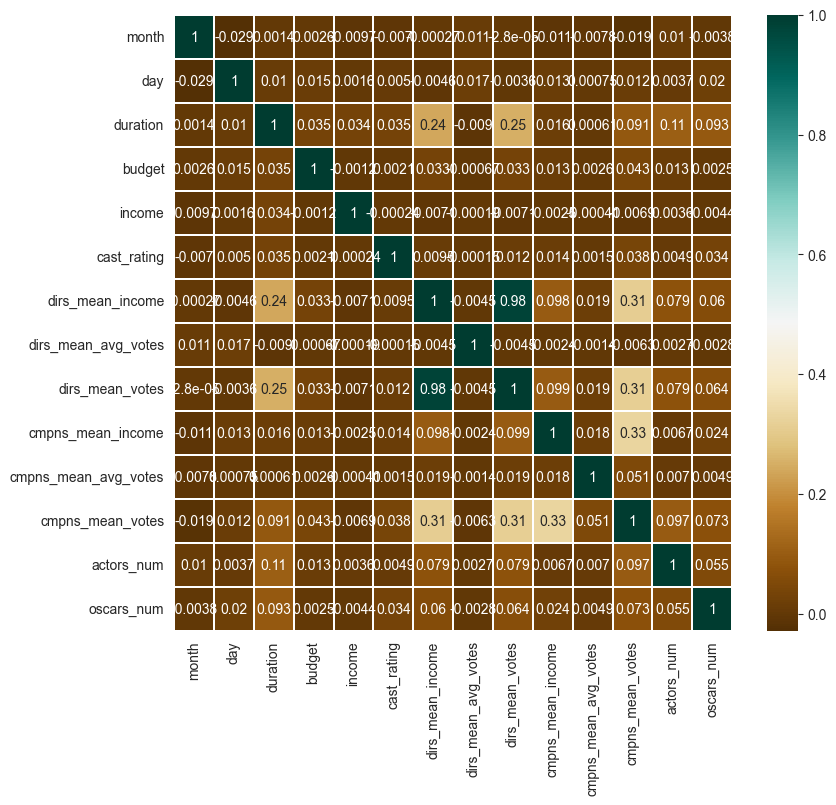

In [315]:
t3 = fin.drop(columns = ['Drama', 'War', 'Adventure', 'Documentary', 'Music', 'Fantasy', 'Crime', 'History', 'Romance', 'Family', 	'Action',	'Musical',	'Sci-Fi',	'Mystery', 'Comedy', 'Thriller',	'Sport',	'Horror',	'Animation', 'Western', 'Biography'])
corr_matrix = t3.corr()

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 8))
sns.heatmap(data = corr_matrix,cmap='BrBG', annot=True, linewidths=0.2)

In [12]:
res = []

for i in range(9):
    for j in range(9):
        s = 0 
        for l in range(3):
            X = fin[(fin['budget'] > 10**i) & (fin['income'] < 10**j)].drop(columns = ['income']).fillna(0)
            Y = fin[(fin['budget'] > 10**i) & (fin['income'] < 10**j)]['income']

            scaler = StandardScaler()
            scaler.fit(X)
            X = scaler.transform(X)

            scaler = MinMaxScaler()
            scaler.fit(Y.to_numpy().reshape(-1, 1))
            y = scaler.transform(Y.to_numpy().reshape(-1, 1))

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            model = MLPRegressor(activation = 'relu', hidden_layer_sizes = (20, 10, 5), learning_rate = 'adaptive', max_iter = 450, solver = 'adam')
            model.fit(X_train, y_train.reshape((X_train.shape[0], )))
            expected_y  = y_test
            predicted_y = model.predict(X_test)
            s += abs(metrics.mean_absolute_error(expected_y, predicted_y)*(max(Y.values) - min(Y.values)) + min(Y.values))
            

        res.append([i, j, s/3])

c:\Users\stan_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
r = pd.DataFrame(res, columns = ['i', 'j', 'res'])
r

i  j         res
0   0  0   76.797886
1   0  1   74.522132
2   0  2   56.672067
3   0  3   45.422539
4   0  4  169.205733
.. .. ..         ...
76  8  4   74.758136
77  8  5   70.155665
78  8  6  112.215676
79  8  7  107.736559
80  8  8  133.857849

[81 rows x 3 columns]

In [16]:
max(r['res'])

2699839.0850294484

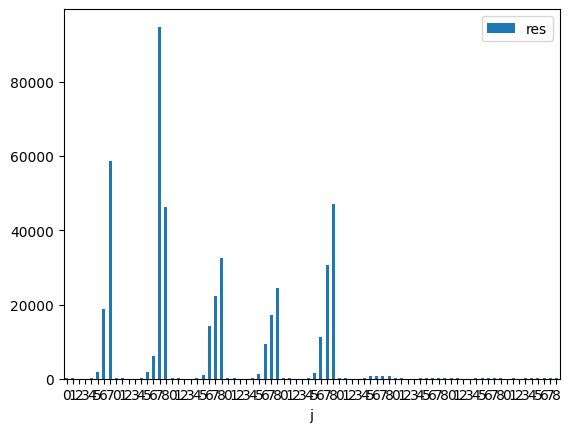

In [17]:
ax = r[r['res'] < 2699839].plot.bar(x='j', y='res', rot=0)

In [14]:
for i in res:
    print(i)

[0, 0, 76.7978856260598]
[0, 1, 74.52213157607194]
[0, 2, 56.67206736608969]
[0, 3, 45.42253917588664]
[0, 4, 169.20573257286762]
[0, 5, 1847.0926340156932]
[0, 6, 18881.107693790986]
[0, 7, 58800.544430858776]
[0, 8, 2699839.0850294484]
[1, 0, 76.4488275435636]
[1, 1, 74.86427790394595]
[1, 2, 55.03311056981193]
[1, 3, 41.01572393340188]
[1, 4, 292.50436980856585]
[1, 5, 1896.5031425607222]
[1, 6, 6223.070013838679]
[1, 7, 94853.36360165027]
[1, 8, 46341.92292410498]
[2, 0, 76.9605912063489]
[2, 1, 74.1929702931214]
[2, 2, 56.149459835979094]
[2, 3, 40.797352855529404]
[2, 4, 221.75194222950438]
[2, 5, 973.4137412507235]
[2, 6, 14274.510822253294]
[2, 7, 22392.944666938758]
[2, 8, 32479.683593643666]
[3, 0, 75.53279338383742]
[3, 1, 74.009530457355]
[3, 2, 58.38966397851141]
[3, 3, 51.89313141241505]
[3, 4, 290.85086673806495]
[3, 5, 1226.913680257267]
[3, 6, 9416.65883118999]
[3, 7, 17094.682192471377]
[3, 8, 24405.068089144563]
[4, 0, 75.7433451195549]
[4, 1, 74.69700628021046]
[4, 

In [19]:
NN = MLPRegressor()

parameter_space = {
    'hidden_layer_sizes': [(20, 10, 5)],#(20,), #(10,30,10)
    'activation': ['relu'],#'identity', 'logistic', 'tanh', 
    'solver': [ 'lbfgs', 'sgd', 'adam'], #'lbfg', 'sgd', 
    'learning_rate': ['adaptive', 'constant', 'invscaling'],# 'invscaling', 'adaptive'],
    #'alpha': [0.0001], #0.001, 
    #'learning_rate': ['adaptive'],
    'max_iter': [325, 400, 500, 550], #, 500
}
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(NN, parameter_space, n_jobs=-1, verbose = 3, cv = 10, scoring = 'neg_mean_absolute_error')

X = fin[(fin['budget'] > 10**0) & (fin['income'] < 10**3)].drop(columns = ['income']).fillna(0)
Y = fin[(fin['budget'] > 10**0) & (fin['income'] < 10**3)]['income']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler = MinMaxScaler()
scaler.fit(Y.to_numpy().reshape(-1, 1))
y = scaler.transform(Y.to_numpy().reshape(-1, 1))

clf.fit(X, y.reshape(X.shape[0], ))


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(20, 10, 5)],
                         'learning_rate': ['adaptive', 'constant',
                                           'invscaling'],
                         'max_iter': [325, 400, 500, 550],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_mean_absolute_error', verbose=3)

In [21]:
clf.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (20, 10, 5),
 'learning_rate': 'constant',
 'max_iter': 325,
 'solver': 'lbfgs'}

In [20]:
clf.best_score_,  -clf.best_score_ * (max(Y.values) - min(Y.values)) + min(Y.values)

(-0.1260264522493189, 38.47119039559419)

In [22]:
NN = MLPRegressor()

parameter_space = {
    'hidden_layer_sizes': [(20, 10, 5)],#(20,), #(10,30,10)
    'activation': ['relu'],#'identity', 'logistic', 'tanh', 
    'solver': [ 'lbfgs', 'sgd', 'adam'], #'lbfg', 'sgd', 
    'learning_rate': ['adaptive', 'constant', 'invscaling'],# 'invscaling', 'adaptive'],
    #'alpha': [0.0001], #0.001, 
    #'learning_rate': ['adaptive'],
    'max_iter': [325, 400, 500, 550], #, 500
}
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(NN, parameter_space, n_jobs=-1, verbose = 3, cv = 10, scoring = 'neg_mean_absolute_error')

X = fin[(fin['budget'] > 10**6) & (fin['income'] < 10**3)].drop(columns = ['income']).fillna(0)
Y = fin[(fin['budget'] > 10**6) & (fin['income'] < 10**3)]['income']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler = MinMaxScaler()
scaler.fit(Y.to_numpy().reshape(-1, 1))
y = scaler.transform(Y.to_numpy().reshape(-1, 1))

clf.fit(X, y.reshape(X.shape[0], ))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(20, 10, 5)],
                         'learning_rate': ['adaptive', 'constant',
                                           'invscaling'],
                         'max_iter': [325, 400, 500, 550],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_mean_absolute_error', verbose=3)

In [23]:
clf.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (20, 10, 5),
 'learning_rate': 'adaptive',
 'max_iter': 325,
 'solver': 'adam'}

In [24]:
clf.best_score_,  -clf.best_score_ * (max(Y.values) - min(Y.values)) + min(Y.values)

(-0.12365531498214458, 35.865938582097556)

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = MLPRegressor(activation = 'relu', hidden_layer_sizes = (20, 10, 5), learning_rate = 'invscaling', max_iter = 325, solver = 'lbfgs')
model.fit(X_train, y_train)
print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)

print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_absolute_error(expected_y, predicted_y)*(max(Y.values) - min(Y.values)) + min(Y.values))

MLPRegressor(hidden_layer_sizes=(20, 10, 5), learning_rate='invscaling',
             max_iter=325, solver='lbfgs')
-0.0012375460512079606
112.93349245671925


c:\Users\stan_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [239]:
clf.predict(X)

array([0.00025761, 0.00025761, 0.00025761, ..., 0.00025761, 0.00025761,
       0.00025761])

<BarContainer object of 12 artists>

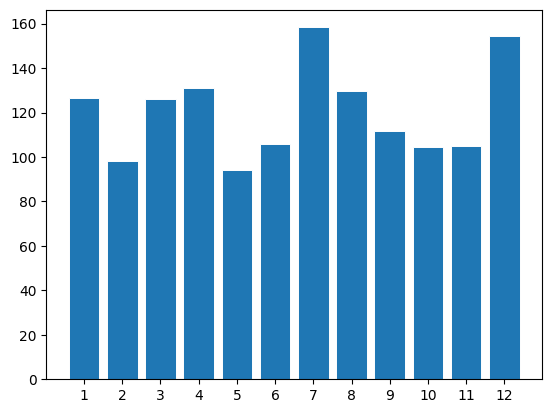

In [100]:
plt.bar(month_str, month_mean, edgecolor="white", linewidth=0.7)

In [101]:
ymd_f = f_5000[['year', 'month', 'day', 'income %']].to_numpy()
ymd_f

array([['1920', '2', '27', -51.05],
       ['1921', '12', '2', -81.85474108601413],
       ['1923', '1', '8', 1047.959125],
       ...,
       ['2012', '7', '28', -99.88018238367002],
       ['2013', '4', '11', -89.25924],
       ['2013', '6', '15', -99.06325]], dtype=object)

In [102]:
ymd_tmp_l = []

from math import isnan

for i in range(len(ymd_f)):
    ymd_tmp_l.append([])
    if isnan(float(ymd_f[i][1])) or isnan(float(ymd_f[i][2])):
        continue

    year = int(ymd_f[i][0])
    month = int(ymd_f[i][1])
    day = int(ymd_f[i][2])

    dateweek = datetime.date(year, month, day).weekday()
    ymd_tmp_l[i].append(dateweek)
    ymd_tmp_l[i].append(ymd_f[i][3])

In [103]:
ymd_tmp_l

[[4, -51.05],
 [4, -81.85474108601413],
 [0, 1047.959125],
 [6, -89.2336],
 [6, -96.7997150997151],
 [0, -97.08385698808235],
 [0, 456.6255894007149],
 [6, -79.62208231421928],
 [5, -97.76912442396313],
 [6, -99.9627],
 [1, -97.00933333333333],
 [5, -99.89744897959184],
 [4, -97.82606666666666],
 [4, -76.12450704225353],
 [4, -97.73869158878504],
 [5, -98.6890185990657],
 [4, -99.63553530751709],
 [4, -99.90283582089552],
 [4, -98.95807692307692],
 [4, -99.63344444444445],
 [4, -17.03005761092904],
 [0, -97.38504473281212],
 [],
 [4, -99.59131147540984],
 [4, -70.31826666666667],
 [4, -99.79447871012327],
 [4, -99.32774974772957],
 [4, -99.0719537815126],
 [4, -98.95806150978565],
 [4, -99.482],
 [4, -98.41252059308073],
 [4, -99.78475],
 [4, -92.38221052631579],
 [6, -95.49339736295704],
 [4, 840.6027367662946],
 [4, -99.04259478672986],
 [4, 3251.377236842105],
 [4, -52.3634],
 [4, -99.6576],
 [4, 4588.155576923077],
 [4, -94.38858695652173],
 [4, 89.8363396675348],
 [4, -99.60726315

In [104]:
day_str = [str(x) for x in range(1, 8)]
day_mean = np.zeros(7)

for i in range(7):
    itc = 0
    for j in range(len(ymd_tmp_l)):
        if ymd_tmp_l[j] and ymd_tmp_l[j][0] == i:
            itc += 1
            day_mean[i] += ymd_tmp_l[j][1]

    day_mean[i] /= itc

day_mean

array([ 72.01839922,  62.93861224,  57.30775857,  12.59232406,
       152.41150712,  44.86894212,  27.88201134])

<BarContainer object of 7 artists>

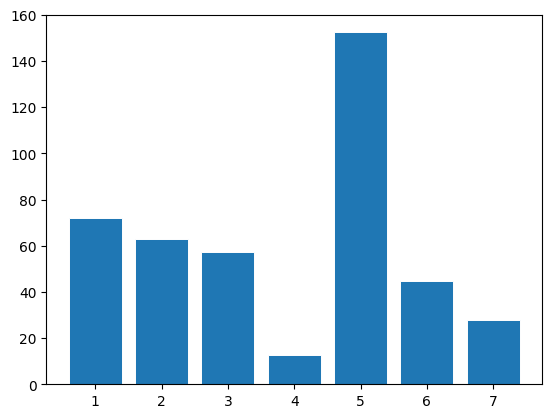

In [105]:
plt.bar(day_str, day_mean, edgecolor="white", linewidth=0.7)

C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\18372750.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(income_5000)


<AxesSubplot: ylabel='Density'>

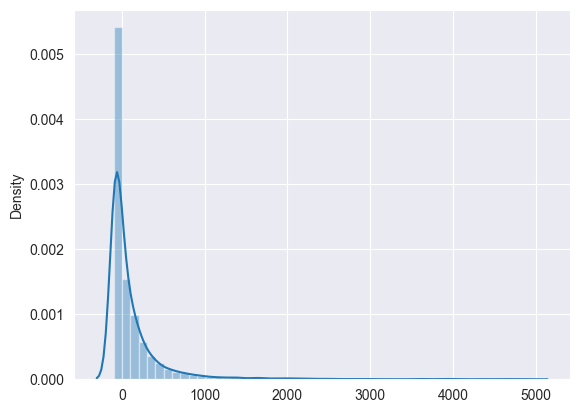

In [106]:
income_5000 = f_5000['income %'].to_numpy()

sns.set_style('darkgrid')
sns.distplot(income_5000)

C:\Users\stan_\AppData\Local\Temp\ipykernel_19672\3995198670.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(income_1000)


<AxesSubplot: ylabel='Density'>

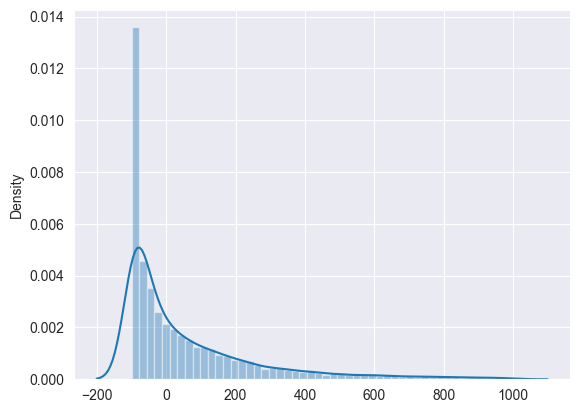

In [107]:
f_1000 = f_5000[f_5000['income %'] <= 1000.0]
income_1000 = f_1000['income %'].to_numpy()

sns.set_style('darkgrid')
sns.distplot(income_1000)

In [108]:
Y = f_1000.loc[:, 'income %']
f_1000_fin = f_1000.drop(columns=['usa_gross_income', 'worlwide_gross_income', 
                                  'income %', 'imdb_title_id', 'title', 'original_title',
                                  'year'])

Neural Networking

In [109]:
# from __future__ import print_function

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable

# class Net(nn.Module):
#    def __init__(self, in_features, out_features):
#        super(Net, self).__init__()
#        self.layer = torch.nn.Linear(in_features, out_features)

#    def forward(self, x):
#        x = self.layer(x)      
#        return x
   
# net = Net()
# print(net)

### Prepared data import

In [110]:
experiment_data = pd.read_csv('2254.csv')
experiment_data.drop(axis=1, columns=['Unnamed: 0'], inplace=True)
experiment_data = experiment_data.dropna()
experiment_data

month  duration  avg_vote   votes       budget  worlwide_gross_income  \
0       4.0       118       6.4   75298  48000000.00             76019048.0   
1      12.0       104       8.1   17693    397883.69               124241.0   
2       7.0       103       6.9    1874   1212420.00                 8144.0   
3      11.0        97       7.3    9084   7715400.00             20424259.0   
4       1.0       112       7.6  107436   8000000.00             43004381.0   
...     ...       ...       ...     ...          ...                    ...   
8326    9.0       106       4.8     556   2000000.00                 2517.0   
8327    4.0       117       5.2     102   3500000.00               103430.0   
8328    7.0       101       5.3    2091   1653300.00                 1984.0   
8329    4.0        98       5.8     224   5000000.00               537038.0   
8330    6.0        98       6.4   13182   4000000.00                37470.0   

          income  Western  Horror  Mystery  ...  Family  Music  \
0      58.373017        0       0        0  ...       0      0   
1     -68.774543        0       0        0  ...       0      0   
2     -99.328286        0       0        0  ...       0      0   
3     164.720676        0       0        0  ...       0      0   
4     437.554762        0       0        0  ...       0      0   
...          ...      ...     ...      ...  ...     ...    ...   
8326  -99.874150        0       0        0  ...       0      0   
8327  -97.044857        0       0        0  ...       0      0   
8328  -99.879998        0       0        0  ...       0      0   
8329  -89.259240        0       0        0  ...       0      0   
8330  -99.063250        0       0        0  ...       0      0   

      dirs_mean_income  dirs_mean_avg_votes  dirs_mean_votes  \
0         58189.239190             7.100000    116268.500000   
1         10976.727472           -41.578579     11025.408333   
2          2181.070678             7.305882      4459.764706   
3             0.000000             0.000000         0.000000   
4         26720.397452             7.225000     53213.500000   
...                ...                  ...              ...   
8326          0.000000           -95.869547         6.800000   
8327          0.000000             0.000000         0.000000   
8328          0.000000             0.000000         0.000000   
8329          0.000000             0.000000         0.000000   
8330          0.000000             0.000000         0.000000   

      cmpns_mean_income  cmpns_mean_avg_votes  cmpns_mean_votes  actors_num  \
0              0.000000              0.000000          0.000000          15   
1           9516.421421              8.150000      19124.000000          15   
2            893.594702              6.725000       1881.250000          15   
3              0.000000              0.000000          0.000000          15   
4          55528.877877              7.372222     110966.277778          15   
...                 ...                   ...               ...         ...   
8326        1642.065227              6.800000       3380.000000          15   
8327           0.000000              0.000000          0.000000           5   
8328           0.000000              0.000000          0.000000          13   
8329           0.000000              0.000000          0.000000          10   
8330       28940.335886              6.500000      57953.500000          15   

      oscars_num  
0              0  
1              2  
2              0  
3              0  
4              0  
...          ...  
8326           0  
8327           0  
8328           0  
8329           0  
8330           0  

[8290 rows x 37 columns]

In [111]:
Y = experiment_data.loc[:, 'income']
X = experiment_data.drop(axis='1', columns=['income', 'votes', 'avg_vote', 'worlwide_gross_income',
                                            'dirs_mean_avg_votes', 'cmpns_mean_avg_votes', 'budget',
                                            'cmpns_mean_income', 'cmpns_mean_votes'])
X

month  duration  Western  Horror  Mystery  History  Comedy  Thriller  \
0       4.0       118        0       0        0        0       1         0   
1      12.0       104        0       0        0        0       1         0   
2       7.0       103        0       0        0        0       1         0   
3      11.0        97        0       0        0        0       1         0   
4       1.0       112        0       0        0        0       0         0   
...     ...       ...      ...     ...      ...      ...     ...       ...   
8326    9.0       106        0       0        0        0       0         1   
8327    4.0       117        0       0        0        0       0         0   
8328    7.0       101        0       0        0        0       0         1   
8329    4.0        98        0       0        0        0       0         0   
8330    6.0        98        0       0        0        0       1         0   

      Musical  Documentary  ...  War  Crime  Romance  Sci-Fi  Family  Music  \
0           0            0  ...    0      0        1       0       0      0   
1           0            0  ...    0      0        0       0       0      0   
2           0            0  ...    0      0        0       0       0      0   
3           0            0  ...    0      0        0       0       0      0   
4           0            0  ...    0      1        0       0       0      0   
...       ...          ...  ...  ...    ...      ...     ...     ...    ...   
8326        0            0  ...    0      0        0       0       0      0   
8327        0            0  ...    0      0        0       0       0      0   
8328        0            0  ...    0      0        0       1       0      0   
8329        0            0  ...    0      0        0       0       0      0   
8330        0            0  ...    0      1        0       0       0      0   

      dirs_mean_income  dirs_mean_votes  actors_num  oscars_num  
0         58189.239190    116268.500000          15           0  
1         10976.727472     11025.408333          15           2  
2          2181.070678      4459.764706          15           0  
3             0.000000         0.000000          15           0  
4         26720.397452     53213.500000          15           0  
...                ...              ...         ...         ...  
8326          0.000000         6.800000          15           0  
8327          0.000000         0.000000           5           0  
8328          0.000000         0.000000          13           0  
8329          0.000000         0.000000          10           0  
8330          0.000000         0.000000          15           0  

[8290 rows x 28 columns]

In [112]:
experiment_data.corr()['income'].sort_values(ascending=False)

income                   1.000000
worlwide_gross_income    0.489063
votes                    0.418818
cmpns_mean_income        0.236097
cmpns_mean_votes         0.235874
avg_vote                 0.234240
dirs_mean_income         0.180665
dirs_mean_votes          0.178164
Adventure                0.098728
duration                 0.094358
dirs_mean_avg_votes      0.077807
actors_num               0.072536
Comedy                   0.063805
Animation                0.059092
Action                   0.045435
Fantasy                  0.042079
oscars_num               0.041349
Family                   0.040476
Sci-Fi                   0.038152
Romance                  0.019475
Horror                   0.017610
Sport                    0.015470
cmpns_mean_avg_votes     0.013978
Mystery                  0.012411
budget                   0.002746
Western                  0.002049
Biography                0.001225
Thriller                -0.000372
Documentary             -0.006775
Music         